In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model,Sequential,load_model
from keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras import backend as K
from google.colab import drive
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

drive.mount('gdrive')
dir = 'gdrive/My Drive/Colab Notebooks/Helmet_Detection/'
history_dict = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': [] }

def build_model(freeze_split = 520):
  print('Building new model. . .')
  # base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
  base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))
  # base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
  print('Base model loaded')

  # for layer in base_model.layers:
  #   layer.trainable = Tr

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # x = Dense(1000, activation='relu')(x) #input = (8,8,2048)
  # x = Dropout(rate = 0.3)(x)
  predictions = Dense(2, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  
  # for layer in model.layers[:freeze_split]:
  #   layer.trainable = False
  # for layer in model.layers[freeze_split:]:
  #   layer.trainable = True


  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy']) #compile 'after' freeze
  # model.summary()
  return model

def k_fold(generator, n_splits, BATCH_SIZE):
  ''' 
    # return: a generator of dict {'train','test','steps_per_fold'} 
  '''
  steps_per_fold = generator.samples // BATCH_SIZE // n_splits
  step = 0
  def generate(fold_type, test_number):
    nonlocal step
    while True:
      np.random.seed(93)
      if step+1 > steps_per_fold*n_splits:
        step = 0
      step+=1
      is_test = (step-1)//steps_per_fold is test_number
      batch = next(generator)
      # if step%steps_per_fold == 1:
      #   print()
      #   print('step',step,fold_type,'is test',is_test)
      #   plt.imshow(batch[0][0])
      #   plt.show()
      if fold_type is 'train' and not is_test:
        # print('step', step, fold_type)
        yield batch
      elif fold_type is 'test' and is_test:
        # print('step', step, fold_type)
        yield batch
      # else:
        # print('step', step, '<skip>',fold_type , steps_per_fold, test_number)

  for n in range(n_splits):
    print('test on fold '+str(n+1)+'/'+str(n_splits))
    yield {'train': generate('train', n), 'test': generate('test', n), 'steps_per_fold':steps_per_fold}


def update_history(history):
  history_dict['acc'] += history.history['acc']
  history_dict['val_acc'] += history.history['val_acc']
  history_dict['loss'] += history.history['loss']
  history_dict['val_loss'] += history.history['val_loss']

def plot_training(min = -1):
  epochs = range(len(history_dict['acc']))
  plt.plot(epochs, history_dict['acc'], 'g--',)
  plt.plot(epochs, history_dict['val_acc'], 'g-')
  if 0 < min < 1:
    plt.ylim(min, 1.) 
  plt.title('Training and validation accuracy')
  # plt.figure()
  # plt.plot(epochs, history_dict['loss'], 'r--')
  # plt.plot(epochs, history_dict['val_loss'], 'r-')
  # plt.title('Training and validation loss')
#       plt.ylim(0., 0.5) 
  plt.show()
#     plt.savefig('gdrive/My Drive/Colab Notebooks/acc_vs_epochs.png')

print('done')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive
done


Found 2400 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
test on fold 1/5
Building new model. . .
Base model loaded
Epoch 1/10
160/160 [==============================] - 565s 4s/step - loss: 0.1446 - acc: 0.9498 - val_loss: 0.1452 - val_acc: 0.9475
Epoch 2/10
160/160 [==============================] - 470s 3s/step - loss: 0.0516 - acc: 0.9815 - val_loss: 0.3962 - val_acc: 0.8225
Epoch 3/10
160/160 [==============================] - 470s 3s/step - loss: 0.0425 - acc: 0.9873 - val_loss: 0.0695 - val_acc: 0.9758
Epoch 4/10
160/160 [==============================] - 470s 3s/step - loss: 0.0241 - acc: 0.9923 - val_loss: 0.1585 - val_acc: 0.9583
Epoch 5/10
160/160 [==============================] - 470s 3s/step - loss: 0.0546 - acc: 0.9831 - val_loss: 0.1777 - val_acc: 0.9383
Epoch 6/10
160/160 [==============================] - 471s 3s/step - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0824 - val_acc: 0.9817
Epoch 7/10
160/160 [==============================] - 469s 

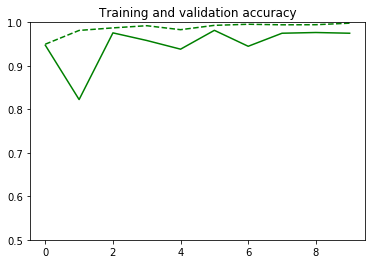

folds acc [0.9637499898672104]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
test on fold 2/5
Building new model. . .
Base model loaded
Epoch 1/10
160/160 [==============================] - 570s 4s/step - loss: 0.1519 - acc: 0.9494 - val_loss: 1.0400 - val_acc: 0.7792
Epoch 2/10
160/160 [==============================] - 467s 3s/step - loss: 0.0695 - acc: 0.9783 - val_loss: 0.0722 - val_acc: 0.9767
Epoch 3/10
160/160 [==============================] - 466s 3s/step - loss: 0.0386 - acc: 0.9852 - val_loss: 0.1172 - val_acc: 0.9708
Epoch 4/10
160/160 [==============================] - 467s 3s/step - loss: 0.0516 - acc: 0.9827 - val_loss: 0.1181 - val_acc: 0.9700
Epoch 5/10
160/160 [==============================] - 467s 3s/step - loss: 0.0353 - acc: 0.9892 - val_loss: 0.1203 - val_acc: 0.9567
Epoch 6/10
160/160 [==============================] - 467s 3s/step - loss: 0.0209 - acc: 0.9952 - val_loss: 0.1644 - val_acc: 0.9567
Epoch 7/10
160/160 [==

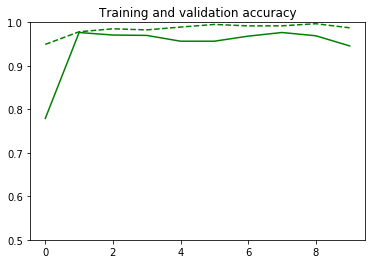

folds acc [0.9637499898672104, 0.9533333212137223]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
test on fold 3/5
Building new model. . .
Base model loaded
Epoch 1/10
126/160 [======================>.......] - ETA: 1:58 - loss: 0.1503 - acc: 0.9429

In [0]:
# K-folds cross validation
BATCH_SIZE = 30
EPOCH = 10
n_split = 5
folds_score = []
INPUT_SHAPE = (299,299)

IDG = ImageDataGenerator(rescale=1./255)
test_generator = IDG.flow_from_directory(dir+'dataset/test', class_mode='categorical',target_size=INPUT_SHAPE, batch_size=BATCH_SIZE, shuffle=True)
data_generator = IDG.flow_from_directory(dir+'dataset/train',class_mode='categorical',target_size=INPUT_SHAPE, batch_size=BATCH_SIZE, shuffle=True)

for data in k_fold(data_generator, n_split, BATCH_SIZE):
  history_dict = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': [] }
  model = build_model()
  
  history = model.fit_generator(data['train'], 
                                epochs = EPOCH, workers = 1,
                                steps_per_epoch = data['steps_per_fold'] * (n_split-1),
                                validation_data = data['test'],
                                validation_steps = data['steps_per_fold'])
  update_history(history) # print each epoch
  plot_training(0.5)
  # epochs end here


  ev = model.evaluate_generator(test_generator)
  folds_score.append(ev[1])
  print('folds acc',folds_score)
  print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
print("Average Accuracy from "+str(n_split)+" split "+str(EPOCH)+ "epochs : "+ str(sum(folds_score)/len(folds_score)) )

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Building new model. . .













219062272/219055592 [==============================] - 3s 0us/step
Base model loaded


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
150/150 [==============================] - 1993s 13s/step - loss: 0.1456 - acc: 0.9494 - val_loss: 0.1282 - val_acc: 0.9525
Epoch 2/10
150/150 [==============================] - 460s 3s/step - loss: 0.0664 - acc: 0.9817 - val_loss: 0.2594 - val_acc: 0.9475
Epoch 3/10
150/150 [==============================] - 459s 3s/step - loss: 0.0565 - acc: 0.9829 - val_loss: 0.0985 - val_acc: 0.9692
Epoch 4/10
150/150 [==============================] - 459s 3s/step - loss: 0.0309 - acc: 0.9906 - val_loss: 0.1192 - val_acc: 0.9708
Epoch 5/10
150/150 [==============================] - 459s 3s/step - loss: 0.0486 - acc: 0.9840 - val_loss: 0.1477 - val

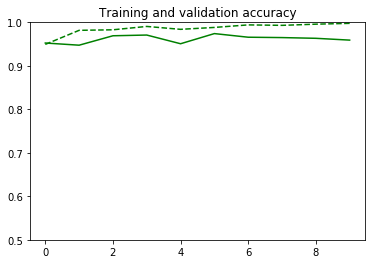

[0.08114197481269608, 0.98125]


In [0]:
# normal split
INPUT_SHAPE = (299,299)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dir+'dataset/train', class_mode='categorical',
                                                  target_size=(299, 299),subset='training')
valid_generator = datagen.flow_from_directory(dir+'dataset/train', class_mode='categorical',
                                                  target_size=(299, 299),subset='validation')
IDG = ImageDataGenerator(rescale=1./255)
test_generator = IDG.flow_from_directory(dir+'dataset/test', class_mode='categorical',
                                         target_size=INPUT_SHAPE)

model = build_model()

history = model.fit_generator(train_generator, epochs = 10, validation_data = valid_generator)
update_history(history)
plot_training(0.5)

ev = model.evaluate_generator(test_generator)
print(ev)

In [0]:
# history = model.fit_generator(train_generator, epochs=5
#                               steps_per_epoch = train_generator.samples//BATCH_SIZE,
#                               validation_data = valid_generator,
#                               validation_steps = valid_generator.samples//BATCH_SIZE,
#                               shuffle = True
#                              )

# plot_training(history)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(dir+'dataset/test', class_mode='categorical',target_size=(299, 299),batch_size=32, shuffle=True)

ev = model.evaluate_generator(test_generator,
                               steps = test_generator.samples//32
                               )
print(model.metrics_names)
print(ev)

--2019-11-06 06:47:25--  https://www.matichon.co.th/wp-content/uploads/2017/12/S__4448593-1024x576.jpg
Resolving www.matichon.co.th (www.matichon.co.th)... 27.254.93.163, 27.254.93.171, 27.254.93.164, ...
Connecting to www.matichon.co.th (www.matichon.co.th)|27.254.93.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104094 (102K) [image/jpeg]
Saving to: ‘S__4448593-1024x576.jpg’

S__4448593-1024x576 100%[===================>] 101.65K   157KB/s    in 0.6s    

2019-11-06 06:47:26 (157 KB/s) - ‘S__4448593-1024x576.jpg’ saved [104094/104094]



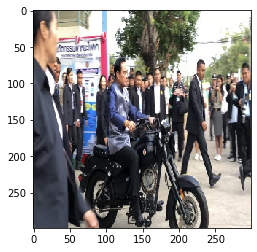

XX No Helmet XX 88.31378817558289%


In [0]:
# online image test
!wget https://www.matichon.co.th/wp-content/uploads/2017/12/S__4448593-1024x576.jpg
file_name = 'S__4448593-1024x576.jpg'
im = image.load_img(file_name, target_size = (299,299))
im = image.img_to_array(im)
im = im/255.

# print(im)
plt.imshow(im)
plt.show()

ans = model.predict([[im]])
print('XX No Helmet XX '+str(ans[0][0]*100)+'%' if ans[0][0] > ans[0][1] else '♪♪ Helmet ♪♪ '+str(ans[0][1]*100)+'%')

In [0]:
# drive image test
drive.mount('gdrive')
total = 0
label = 'no'
set = 'train'
start,stop = 3001,4201
if set is 'train':
  start,stop = 1,3001
for n in range(start,stop):
  img = None
  img = Image.open(dir+'dataset/'+set+'/'+label+'/'+label+'_'+str(n)+'.jpg')
  im = image.img_to_array(img)
  im = im/255.
  
  ans = model.predict([[im]])
  no = ans[0][0]
  yes = ans[0][1]
  if no < 0.5:
    total += 1
    print('#'+str(n), end=' ')
    print('XX No Helmet XX '+str(ans[0][0]*100)+'%' if no > 0.5 else '♪♪ Helmet ♪♪ '+str(ans[0][1]*100)+'%')
    if no < 0.5:
      plt.imshow(im)
      plt.show()
print('detect:',total,'out of',stop-start)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
model_name = 'inceptionResNetV2_BEST.h5'
model.save(dir+'model/'+model_name)
# model = load_model(dir+'model/'+model_name)
# print('model loaded')

In [0]:
plot_training(history)

TEST ZONE

In [0]:
IDG = ImageDataGenerator(rescale=1./255)
data_generator = IDG.flow_from_directory(dir+'dataset/test',class_mode='categorical',target_size=(299, 299),batch_size=30,shuffle=True)

for data in k_fold(data_generator, 5, 30):
  for epoch in range(3):
    for i in range(data['steps_per_fold']*4):
      train = next(data['train'])
      if i%data['steps_per_fold'] == 0:
        print('        train','step',i+1,'epoch',epoch)
        plt.imshow(train[0][0])
        plt.show()
    for i in range(data['steps_per_fold']):
      test = next(data['test'])
      if i == 0:
        print('         test','epoch',epoch)
        plt.imshow(test[0][0])
        plt.show()

In [0]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(len(base_model.layers))
base_model.summary()

780
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 111, 111, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 111, 111, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________